## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
# from imgaug import augmenters as iaa
import cv2

## Load Dataset

Here, we are using numpy as Keras is used with numpy

In [2]:
## Load Dataset
def load_dataset():
    datasets = ['real', 'easy', 'medium', 'hard']
    data_dict = {}
    for dataset in datasets:
        x_data = np.load(f'dataset/x_{dataset}.npy')
        y_data = np.load(f'dataset/y_{dataset}.npy')
        data_dict[dataset] = (x_data, y_data)
        print(f"{dataset}: X shape {x_data.shape}, Y shape {y_data.shape}")

    return data_dict

data_dict = load_dataset()

real: X shape (6000, 90, 90), Y shape (6000, 4)
easy: X shape (17931, 90, 90), Y shape (17931, 4)
medium: X shape (17067, 90, 90), Y shape (17067, 4)
hard: X shape (14272, 90, 90), Y shape (14272, 4)


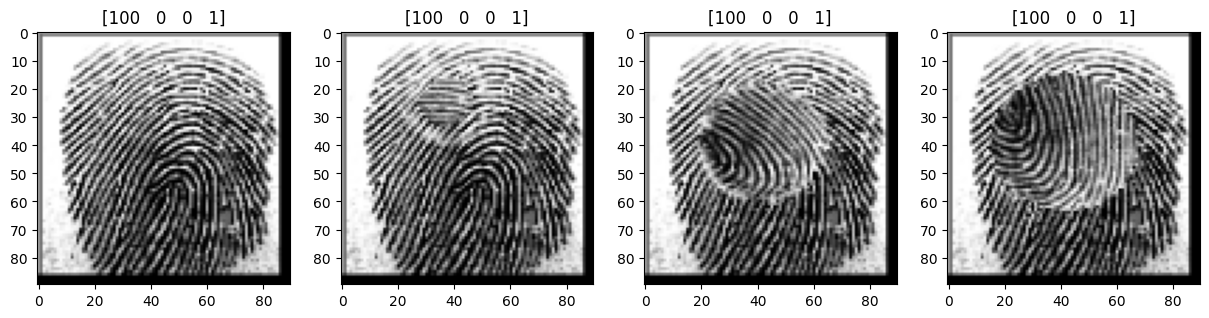

In [3]:
# Visualize a sample from each dataset
def visualize_samples(data_dict):
    plt.figure(figsize=(15, 10))
    for idx, (key, (x, y)) in enumerate(data_dict.items(), start=1):
        plt.subplot(1, 4, idx)
        plt.title(y[0])
        plt.imshow(x[0].squeeze(), cmap='gray')
    plt.show()

visualize_samples(data_dict)

# Train Test Split

In [4]:
x_data = np.concatenate([data_dict['easy'][0], data_dict['medium'][0], data_dict['hard'][0]], axis=0)
label_data = np.concatenate([data_dict['easy'][1], data_dict['medium'][1], data_dict['hard'][1]], axis=0)

# we use 90/10 split
x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)
print(f"x_train: {x_train.shape}, label_train: {label_train.shape}")
print(f"x_val: {x_val.shape}, label_val: {label_val.shape}")

x_train: (44343, 90, 90), label_train: (44343, 4)
x_val: (4927, 90, 90), label_val: (4927, 4)


## Preview Augmentation

These are functions and transformations that will serve to transform and distort the original image that we will use for testing the trained model.


In [5]:
# def preview_augmentation(images):
#     seq = iaa.Sequential([
#         iaa.GaussianBlur(sigma=(0, 0.5)),
#         iaa.Affine(
#             scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
#             rotate=(-30, 30),
#             order=[0, 1],
#             cval=255
#         )
#     ], random_order=True)

#     augmented_images = seq.augment_images(images)
    
#     plt.figure(figsize=(16, 6))
#     plt.subplot(2, 5, 1)
#     plt.title('Original')
#     plt.imshow(images[0].squeeze(), cmap='gray')
#     for i, aug in enumerate(augmented_images):
#         plt.subplot(2, 5, i + 2)
#         plt.title(f'Aug {i + 1}')
#         plt.imshow(aug.squeeze(), cmap='gray')
#     plt.show()

# preview_augmentation([x_data[40000]] * 9)

def preview_augmentation(images):
    augmented_images = []
    
    for _ in range(9):
        img = images[0].copy()
        
        # Apply Gaussian blur
        blur_strength = random.uniform(0, 0.5)
        if blur_strength > 0:
            blur_size = int(blur_strength * 10) * 2 + 1  # Must be odd number
            img = cv2.GaussianBlur(img, (blur_size, blur_size), blur_strength)
        
        # Apply affine transformations
        h, w = img.shape[:2]
        
        # Random scale
        scale_x = random.uniform(0.9, 1.1)
        scale_y = random.uniform(0.9, 1.1)
        
        # Random translation
        tx = random.uniform(-0.1, 0.1) * w
        ty = random.uniform(-0.1, 0.1) * h
        
        # Random rotation
        angle = random.uniform(-30, 30)
        
        # Compute affine transform matrix
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        M[0, 0] *= scale_x
        M[1, 1] *= scale_y
        M[0, 2] += tx
        M[1, 2] += ty
        
        # Apply affine transform
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
        
        augmented_images.append(img)
    
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 5, 1)
    plt.title('Original')
    plt.imshow(images[0].squeeze(), cmap='gray')
    for i, aug in enumerate(augmented_images):
        plt.subplot(2, 5, i + 2)
        plt.title(f'Aug {i + 1}')
        plt.imshow(aug.squeeze(), cmap='gray')
    plt.show()


## Make Label Dictionary Lookup Table

This is used later on, to find the original index of a randomly picked sample from the validation set in order to compare the images for the testing.

In [6]:
label_real_dict = {''.join(y.astype(str)).zfill(6): i for i, y in enumerate(data_dict['real'][1])}

## Data Generator

This is necessary step in image processing using Keras, especially a big dataset that cannot fit into the memory during training. It is a class that produces batches of data that can feed into multiple cores right away.

In [11]:
# class DataGenerator(keras.utils.Sequence):
#     def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
#         self.x = x
#         self.label = label
#         self.x_real = x_real
#         self.label_real_dict = label_real_dict
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         return len(self.x) // self.batch_size

#     def __getitem__(self, index):
#         x1_batch = self.x[index * self.batch_size:(index + 1) * self.batch_size]
#         label_batch = self.label[index * self.batch_size:(index + 1) * self.batch_size]
        
#         x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
#         y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
#         if self.shuffle:
#             seq = iaa.Sequential([
#                 iaa.GaussianBlur(sigma=(0, 0.5)),
#                 iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
#                         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
#                         rotate=(-30, 30),
#                         order=[0, 1], cval=255)
#             ], random_order=True)
#             x1_batch = seq.augment_images(x1_batch)
        
#         for i, l in enumerate(label_batch):
#             match_key = ''.join(l.astype(str)).zfill(6)
#             if random.random() > 0.5:
#                 x2_batch[i] = self.x_real[self.label_real_dict[match_key]][..., np.newaxis]
#                 y_batch[i] = 1.
#             else:
#                 while True:
#                     unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
#                     if unmatch_key != match_key:
#                         x2_batch[i] = self.x_real[unmatch_idx][..., np.newaxis]
#                         break
#                 y_batch[i] = 0.
                
#         return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

#     def on_epoch_end(self):
#         if self.shuffle:
#             self.x, self.label = shuffle(self.x, self.label)

# class DataGenerator(keras.utils.Sequence):
#     def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
#         self.x = x
#         self.label = label
#         self.x_real = x_real
#         self.label_real_dict = label_real_dict
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end()
    
#     def __len__(self):
#         return len(self.x) // self.batch_size
    
#     def __getitem__(self, index):
#         x1_batch = self.x[index * self.batch_size:(index + 1) * self.batch_size].copy()
#         label_batch = self.label[index * self.batch_size:(index + 1) * self.batch_size]
        
#         x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
#         y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
#         if self.shuffle:
#             # Apply augmentations
#             for i in range(len(x1_batch)):
#                 img = x1_batch[i].copy()
                
#                 # Apply Gaussian blur
#                 blur_strength = random.uniform(0, 0.5)
#                 if blur_strength > 0:
#                     blur_size = int(blur_strength * 10) * 2 + 1  # Must be odd number
#                     img = cv2.GaussianBlur(img, (blur_size, blur_size), blur_strength)
                
#                 # Apply affine transformations
#                 h, w = img.shape[:2]
                
#                 # Random scale
#                 scale_x = random.uniform(0.9, 1.1)
#                 scale_y = random.uniform(0.9, 1.1)
                
#                 # Random translation
#                 tx = random.uniform(-0.1, 0.1) * w
#                 ty = random.uniform(-0.1, 0.1) * h
                
#                 # Random rotation
#                 angle = random.uniform(-30, 30)
                
#                 # Compute affine transform matrix
#                 center = (w // 2, h // 2)
#                 M = cv2.getRotationMatrix2D(center, angle, 1.0)
#                 M[0, 0] *= scale_x
#                 M[1, 1] *= scale_y
#                 M[0, 2] += tx
#                 M[1, 2] += ty
                
#                 # Apply affine transform
#                 img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
                
#                 x1_batch[i] = img
        
#         for i, l in enumerate(label_batch):
#             match_key = ''.join(l.astype(str)).zfill(6)
#             if random.random() > 0.5:
#                 x2_batch[i] = self.x_real[self.label_real_dict[match_key]][..., np.newaxis]
#                 y_batch[i] = 1.
#             else:
#                 while True:
#                     unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
#                     if unmatch_key != match_key:
#                         x2_batch[i] = self.x_real[unmatch_idx][..., np.newaxis]
#                         break
#                 y_batch[i] = 0.
        
#         return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.x, self.label = shuffle(self.x, self.label)

class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.x) // self.batch_size
    
    def __getitem__(self, index):
        x1_batch = self.x[index * self.batch_size:(index + 1) * self.batch_size].copy()
        label_batch = self.label[index * self.batch_size:(index + 1) * self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # Apply augmentations if shuffle is True
        if self.shuffle:
            # Apply OpenCV augmentations as in previous example
            for i in range(len(x1_batch)):
                # Augmentation code as provided earlier
                pass
        
        for i, l in enumerate(label_batch):
            match_key = ''.join(l.astype(str)).zfill(6)
            if random.random() > 0.5:
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]][..., np.newaxis]
                y_batch[i] = 1.
            else:
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                    if unmatch_key != match_key:
                        x2_batch[i] = self.x_real[unmatch_idx][..., np.newaxis]
                        break
                y_batch[i] = 0.
        
        # Return data in a format TensorFlow expects
        # Instead of returning [x1_batch, x2_batch], y_batch
        # Create a tuple of inputs
        x_input = (
            x1_batch.astype(np.float32) / 255., 
            x2_batch.astype(np.float32) / 255.
        )
        
        return x_input, y_batch
    
    def on_epoch_end(self):
        if self.shuffle:
            self.x, self.label = shuffle(self.x, self.label)

In [12]:
# Here we create the DataGenerator class for train and validation set
train_gen = DataGenerator(x_train, label_train, data_dict['real'][0], label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, data_dict['real'][0], label_real_dict, shuffle=False)

## Create Model

Here is the concept of the model:
- 2 models with 2x Convolutional and Pooling layers, sharing weights
- The outputs are subtracted, and the subtraction is fed to another Conv + Pooling layer
- Then that is fed to a sigmoid for final classification if the 2 images are same or not

![image.png](attachment:image.png)

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Subtract
from tensorflow.keras.models import Model

def create_base_network(input_shape):
    """
    Function to create the base network (twin network) for the Siamese architecture.
    """
    input = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Flatten the feature map
    x = Flatten()(x)

    return Model(input, x)

# Define the input shape for the images
input_shape = (90, 90, 1)

# Create the twin networks (base networks with shared weights)
base_network = create_base_network(input_shape)

# Define two input tensors for the two images
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Process each image through the shared twin network
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the absolute difference between the feature vectors
subtracted = Subtract()([processed_a, processed_b])

# Further processing of the subtracted feature using another convolutional layer
x = Dense(128, activation='relu')(subtracted)
x = Dropout(0.5)(x)

# Output layer with sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(x)

# Create the full Siamese network model
model = Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 30976)     │     18,816 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 30976)     │          0 │ functional_2[0][… │
│ (Subtract)          │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,965,056 │ subtract_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,984,001 (15.20 MB)

 Trainable params: 3,984,001 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In other versons of the solutions, they used fit_generator method, which was commonly used in older versions of Keras to train models using data generators. However, since TensorFlow 2.1, fit can handle data generators directly. This unifies the API, making the code cleaner and more consistent. It also allows for better integration with TensorFlow’s functionalities such as distributed training and callbacks. Hence, using fit instead of fit_generator is the recommended approach now.

In [14]:
# Train the model using model.fit
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)

Epoch 1/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 129s 92ms/step - accuracy: 0.9029 - loss: 0.2275 - val_accuracy: 0.9929 - val_loss: 0.0226
Epoch 2/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 142s 102ms/step - accuracy: 0.9915 - loss: 0.0332 - val_accuracy: 0.9988 - val_loss: 0.0069
Epoch 3/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 161s 116ms/step - accuracy: 0.9952 - loss: 0.0177 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 4/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 163s 118ms/step - accuracy: 0.9961 - loss: 0.0141 - val_accuracy: 0.9971 - val_loss: 0.0076
Epoch 5/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 158s 114ms/step - accuracy: 0.9960 - loss: 0.0146 - val_accuracy: 0.9975 - val_loss: 0.0068
Epoch 6/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 162s 117ms/step - accuracy: 0.9973 - loss: 0.0107 - val_accuracy: 0.9971 - val_loss: 0.0107
Epoch 7/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 159s 114ms/step - accuracy: 0.9966 - loss: 0.0137 - val_accuracy: 0.9971 - val_loss: 0.0104
Epoch 8/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 160s 115ms/step - acc

## Evaluation

This is just a test using one random image and

In [42]:
import os
import tensorflow as tf
def save_models(model, output_dir='../fingerprint_models'):
    """
    Save the trained Siamese model to disk using Keras's H5 format and TensorFlow's SavedModel format
    
    Parameters:
    model: Trained Siamese network model
    output_dir: Directory to save model in
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Method 1: Save with .keras extension (newer Keras versions prefer this)
    model.save(os.path.join(output_dir, 'fingerprint_siamese_model.keras'))
    
    # Method 2: Alternative - save as SavedModel directory format
    tf.saved_model.save(model, os.path.join(output_dir, 'fingerprint_siamese_model_saved'))
    
    print(f"Model saved to {output_dir}/")

# Update the load_models function to match
def load_models(model_dir='fingerprint_models'):
    """
    Load the trained model from disk
    
    Parameters:
    model_dir: Directory containing saved model
    
    Returns:
    fingerprint_model
    """
    try:
        # Try loading using .keras extension first
        model = tf.keras.models.load_model(os.path.join(model_dir, 'fingerprint_siamese_model.keras'))
    except:
        # Fallback to SavedModel format
        model = tf.keras.models.load_model(os.path.join(model_dir, 'fingerprint_siamese_model_saved'))
    
    return model

In [43]:
save_models(model)

INFO:tensorflow:Assets written to: ../fingerprint_models\fingerprint_siamese_model_saved\assets


INFO:tensorflow:Assets written to: ../fingerprint_models\fingerprint_siamese_model_saved\assets


Model saved to ../fingerprint_models/


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


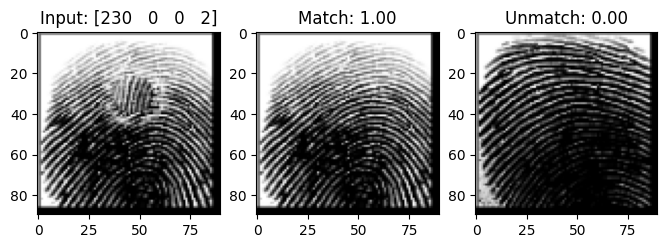

In [33]:
def evaluate_model(model, x_val, label_val):
    random_idx = random.randint(0, len(x_val))
    random_img = x_val[random_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    match_key = ''.join(label_val[random_idx].astype(str)).zfill(6)
    
    matched_img = data_dict['real'][0][label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    pred_matched = model.predict([random_img, matched_img])[0][0]
    
    unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
    unmatched_img = data_dict['real'][0][unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    pred_unmatched = model.predict([random_img, unmatched_img])[0][0]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.title(f'Input: {label_val[random_idx]}')
    plt.imshow(random_img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f'Match: {pred_matched:.2f}')
    plt.imshow(matched_img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title(f'Unmatch: {pred_unmatched:.2f}')
    plt.imshow(unmatched_img.squeeze(), cmap='gray')
    plt.show()

evaluate_model(model, x_val, label_val)